## Notes sur le laboratoire

### Utilisation de commandes

Dans ce laboratoire, il est parfois intéressant (mais pas nécessaire à strictement parler) d'entrer certaines commandes dans le terminal (ou ligne de commande). Dans l'explorateur de fichiers de Jupyter Notebook, il est très simple d'ouvrir un terminal via le menu New (ou Nouveau):

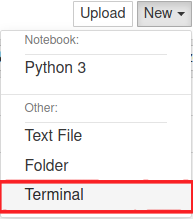

Par contre, il n'est malheureusement pas possible d'obtenir un terminal si Google Colab est utilisé.

### Utilisation de Google Colab

Si vous utilisez Google Colab, suivez les instructions ci-dessous.

Tout d'abord, sélectionnez l'option GPU de Colab avec *Edit > Notebook settings* et sélectionner GPU comme Hardware accelerator. Installer ensuite deeplib avec la commande suivante:

In [2]:
!pip install git+https://github.com/ulaval-damas/glo4030-labs.git

  Cloning https://github.com/ulaval-damas/glo4030-labs.git to /tmp/pip-req-build-cbzn84aa
  Running command git clone --filter=blob:none --quiet https://github.com/ulaval-damas/glo4030-labs.git /tmp/pip-req-build-cbzn84aa
  Resolved https://github.com/ulaval-damas/glo4030-labs.git to commit c15d28e9050701a5555ed3f2f1421840cde5e113
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 93.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.4/214.4 kB 26.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 96.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 71.5 MB/s eta 0:00:00
  Created wheel for deeplib: filename=deeplib-0.1-py3-none-any.whl size=10542 sha256=385377b2270fca57e44429261ea2e46727ef022417e972849c13711ec731d8a4
  Stored in directory: /tmp/pip-ephem-wheel-cache-0sao8xnj/wheels/9f/29/ed/25822e0088ad9c46b352ed51c58696b9d13fbc94e1db2ac759
Successfully built deeplib


# Laboratoire 1: Introduction à PyTorch

Le but de ce laboratoire est de se familiariser avec PyTorch en l'utilisant pour faire de la classification sur deux jeux de données connus: MNIST et CIFAR-10. On aura donc une vue d'ensemble de l'utilisation de PyTorch. Prenez donc le temps de lire le code et d'essayer de comprendre en haut niveau ce qui se passe.

La cellule ci-dessous importe les différents modules qui sont utilisés dans ce notebook. Notamment, en plus de différents modules de PyTorch (torch.\*), on importe deeplib qui est une libraire écrite spécialement pour les notebook de ce cours.

In [3]:
import os
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import time
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.dpi'] = 150

from deeplib.datasets import load_mnist, load_cifar10, train_valid_loaders
from sklearn.metrics import accuracy_score
from deeplib.net import MnistNet, CifarNet
from deeplib.history import History
from deeplib.visualization import plot_images

from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

## MNIST

MNIST est un jeu de données contenant des images de chiffres manuscrits.

Le jeu de données est séparé comme suit: 50 000 images sont utilisées en entraînement et 10 000 en test.

Pour obtenir les objets [`Dataset`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) de PyTorch pour les exemples d'entraînement et de test, on utilise la fonction `load_mnist` dans deeplib qui utilise la librairie [`torchvision`](https://pytorch.org/vision/main/) sous le capot.

In [4]:
mnist, mnist_test = load_mnist()

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 506kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.73MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.34MB/s]


### Visualisation du jeu de données

Exécuter cette cellule plusieurs fois pour visualiser différents exemples du jeu de données.

La fonction `plot_images` est une fonction venant de deeplib.

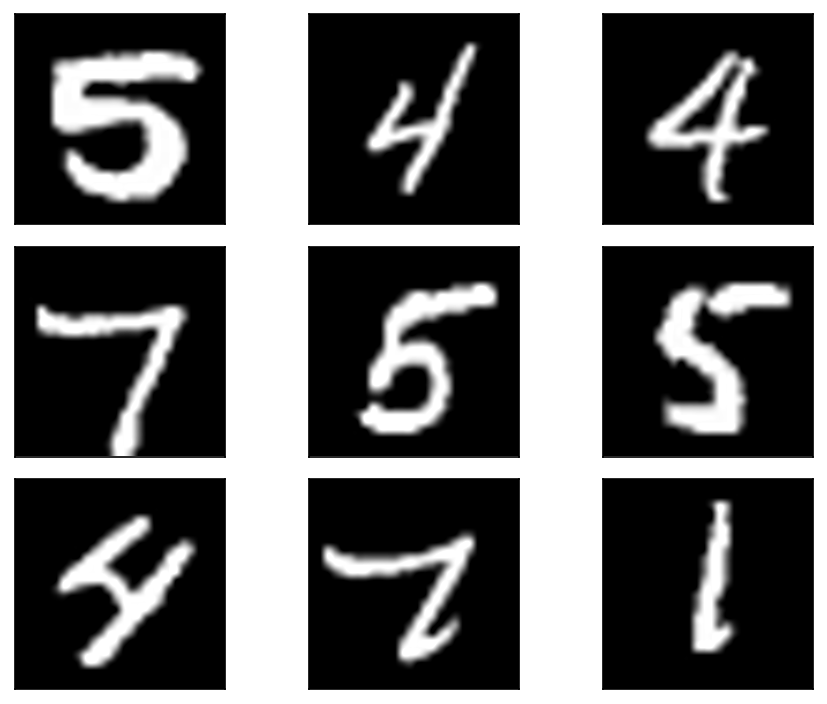

In [6]:
idx = random.sample([x for x in range(len(mnist))], 9)
images = [np.array(mnist[i][0]) for i in idx]
targets = [mnist[i][1] for i in idx]

plot_images(images, targets, gray=True)

On peut indexer les datasets de PyTorch comme une liste. Généralement, chaque élément d'un dataset va être un tuple `(x, y)`. Le terme `x` va correspondre à notre exemple. Le terme `y` va correspondre à notre étiquette (ou label, target) sous forme d'index (par exemple, on pourrait avoir 0 pour chien et 1 pour chat si on cherchait à différencier des images de chats et de chien). Avec MNIST, `x` sera les pixels de l'image et `y` sera le chiffre à classifier.

Les cellules ci-dessous affichent le premier élément `(x, y)` du jeu de données.

In [7]:
x, y = mnist[0]
x, y

(<PIL.Image.Image image mode=L size=28x28>, 5)

On affiche l'image `x`.

In [8]:
x

On affiche l'étiquette `y`.

In [9]:
y

5

Les datasets de torchvision ont un attribut permettant d'effectuer une transformation sur nos images. Dans notre cas, on veut simplement obtenir un tenseur pour PyTorch.

In [10]:
mnist.transform = ToTensor()
mnist_test.transform = ToTensor()

## Entraînement

Pour l'entraînement, on a besoin d'une fonction ``train`` pour entraîner le réseau, d'une fonction ``validate`` pour estimer la performance de notre modèle au fur et à mesure de l'optimisation et d'une fonction ``test`` pour estimer la performance de notre modèle sur des données jamais observées.

Pour chaque epoch, la fonction ``train`` passe au travers de toutes les images du jeu de données dans un ordre aléatoire et met à jour les poids du réseau selon la perte calculée.<br>
Pour entraîner le réseau, la fonction doit recevoir 3 hyperparamètres:
1. le nombre d'epochs qui indique combien de fois toutes les images du jeu de données seront observées;
2. la taille de la batch qui indique combien d'images seront traitées à la fois;
3. le taux d'apprentissage qui détermine la vitesse à laquelle chaque poids du réseau sera modifié.

Pendant l'entraînement, une partie des données est utilisée pour créer un ensemble de validation qui permet d'estimer les performances de généralisation du modèle.

Finalement, on sauvegarde aussi quelques informations importantes afin de visualiser ce qui se passe pendant l'entraînement.

Le code est commenté pour donner plus de détails du déroulement de l'entraînement et des subtilités de PyTorch. Vous aurez l'occasion dans les prochains laboratoires de mieux comprendre tous ces détails.

In [5]:
def train(model, dataset, n_epoch, batch_size, learning_rate, use_gpu=False):
    """
    Entraîne un réseau de neurones de classification pour un certain nombre d'epochs
    avec PyTorch.

    Args:
        model (nn.Module): Un réseau de neurones instancié avec PyTorch.
        dataset (Dataset): Un jeu de données PyTorch.
        n_epoch (int): Le nombre d'epochs.
        batch_size (int): La taille des batchs.
        learning_rate (float): Le taux d'apprentissage pour SGD.
        use_gpu (bool): Si les données doivent être envoyées sur GPU.

    Returns:
        Retourne un objet History permettant de faire des graphiques
        de l'évolution de l'entraînement.
    """
    # La classe History vient de deeplib. Elle va nous permettre de faire les graphiques
    # donnant l'évolution de la perte et de l'exactitude (accuracy).
    history = History()

    # La fonction de perte que nous utilisons ici est l'entropy croisée
    # L'optimiseur que nous utilisons ici est le classique SGD.
    # Des liens vers la documentation de PyTorch sont en commentaires.
    criterion = nn.CrossEntropyLoss()  # https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)  # https://pytorch.org/docs/stable/optim.html#torch.optim.SGD

    # La fonction train_valid_loaders vient de deeplib. Elle nous retourne deux DataLoaders:
    # un pour l'ensemble d'entraînement et un pour l'ensemble de test. Essentiellement,
    # DataLoader est une classe de PyTorch nous permettant de faire des batchs avec la taille
    # désirée. La fonction train_valid_loaders effectue la répartition aléatoire des exemples
    # en entraînement et en validation.
    train_loader, valid_loader = train_valid_loaders(dataset, batch_size=batch_size)

    # C'est ici que la boucle d'entraînement commence. On va donc faire n_epochs epochs.
    for i in range(n_epoch):
        # Les réseaux de neurones avec PyTorch ont un méthode train() en plus d'une méthode
        # eval(). Ces deux méthodes indiquent au réseau s'il est en entraînement ou bien en test.
        # Ceci permet au réseau de modifier son comportement en fonction. On va le voir plus tard
        # certaines couches agissent différemment selon le mode, nommément le dropout et la
        # batch normalization.
        model.train()

        # La prochaine ligne active simplement le calcul du gradient. Le gradient est ce qui va
        # nous permettre de mettre à jour les poids du réseau de neurones. En test, le calcul du
        # gradient sera désactivé étant qu'il n'est pas nécessaire et qu'il peut engendrer des
        # fuites de mémoire si la rétro-propagation n'est pas effectuée.
        with torch.enable_grad():
            # À chaque epoch, on parcourt l'ensemble d'entraînement au complet via le DataLoader
            # qui nous le retourne en batch (x, y) comme mentionné plus haut. La variable inputs
            # correspond donc à une batch d'exemples (x) et targets correspond à une batch
            # d'étiquettes (y).
            for inputs, targets in train_loader:
                # On envoie les exemples et leurs étiquettes sur GPU via la méthode cuda() si
                # demandé.
                if use_gpu:
                    inputs = inputs.cuda()
                    targets = targets.cuda()

                # La méthode zero_grad() de l'optimiseur permet de mettre la valeur du gradient
                # à zéro de façon à effacer le gradient calculé auparavant. Si ceci n'était pas
                # fait, le nouveau gradient serait additionné à l'ancien gradient ce qui poserait
                # problème.
                optimizer.zero_grad()

                # C'est ici que finalement le réseau de neurones est appelé. On lui donne en entrée
                # un exemple et en sortie il nous donne ses prédictions (ici, des scores de
                # classification).
                output = model(inputs)

                # Une fois nos prédictions obtenues, on calcule la perte avec la fonction de perte
                # qui nous retourne un tenseur scalaire.
                loss = criterion(output, targets)
                # Ce tenseur scalaire nous permet de calculer le gradient. C'est ce que la méthode
                # backward() vient faire pour nous via la rétropropagation.
                loss.backward()
                # Une fois que le gradient est calculé, il ne reste que mettre à jour les poids du
                # réseau de neurones. C'est ce que la méthode step() de l'optimiseur vient faire
                # pour nous.
                optimizer.step()

        # Après chaque epoch d'entraînement, on va venir calculer la perte et l'exactitude
        # (accuracy) sur l'ensemble d'entraînement et de validation.
        train_acc, train_loss = validate(model, train_loader, use_gpu)
        val_acc, val_loss = validate(model, valid_loader, use_gpu)
        history.save(dict(acc=train_acc, val_acc=val_acc, loss=train_loss, val_loss=val_loss, lr=learning_rate))
        print(f'Epoch {i} - Train acc: {train_acc:.2f} - Val acc: {val_acc:.2f} - Train loss: {train_loss:.4f} - Val loss: {val_loss:.4f}')

    return history

Pour chaque image du jeu de donnée, la fonction ``validate`` fait prédire une classe au réseau entraîné et compare le résultat avec la vraie réponse. Elle retourne le pourcentage de réponse correcte (c'est-à-dire l'exactitude, ou *accuracy* en anglais) ainsi que la perte moyenne.

In [6]:
def validate(model, valid_loader, use_gpu=False):
    """
    Test un réseau de neurones de classification pour un certain nombre d'epochs
    avec PyTorch.

    Args:
        model (nn.Module): Un réseau de neurones instancié avec PyTorch.
        valid_loader (DataLoader): Un DataLoader PyTorch tel qu'instancié dans train()
            et test().
        use_gpu (bool): Si les données doivent être envoyées sur GPU.

    Returns:
        Retourne un tuple (exactitude, perte) pour les données du DataLoader en argument.
    """

    # Les étapes de la fonction validate est très similaire à celle de la fonction train.
    # Essentiellement, le réseau est mis en mode évaluation au lieu d'entraînement et le
    # calcul du gradient est désactivé. Il n'y a bien sûr pas d'utilisation d'un optimiseur.
    true = []
    pred = []
    val_loss = []

    criterion = nn.CrossEntropyLoss()
    model.eval()
    with torch.no_grad():
        for inputs, targets in valid_loader:
            if use_gpu:
                inputs = inputs.cuda()
                targets = targets.cuda()

            output = model(inputs)

            predictions = output.max(dim=1)[1]

            val_loss.append(criterion(output, targets).item())
            true += targets.cpu().numpy().tolist()
            pred += predictions.cpu().numpy().tolist()

    return accuracy_score(true, pred) * 100, sum(val_loss) / len(val_loss)

La fonction `test` est utilisée à la fin de l'entraînement sur l'ensemble de test et affiche le pourcentage de réponse correcte ainsi que la perte moyenne sur cet ensemble.

In [7]:
def test(model, dataset, batch_size, use_gpu=False):
    """
    Test un réseau de neurones de classification pour un certain nombre d'epochs
    avec PyTorch. La fonction affiche l'exactitude et la perte moyenne.

    Args:
        model (nn.Module): Un réseau de neurones instancié avec PyTorch.
        dataset (Dataset): Un jeu de données PyTorch.
        batch_size (int): La taille des batchs.
        use_gpu (bool): Si les données doivent être envoyées sur GPU.
    """
    test_loader = DataLoader(dataset, batch_size=batch_size)
    test_acc, test_loss = validate(model, test_loader, use_gpu=use_gpu)
    print('Test acc: {:.2f} - Test loss: {:.4f}'.format(test_acc, test_loss))

Entraînons un modèle.

In [14]:
model = MnistNet()
model.cuda()

n_epoch = 10
batch_size = 64
learning_rate = 0.1

history = train(model, mnist, n_epoch, batch_size, learning_rate, use_gpu=True)

Epoch 0 - Train acc: 96.47 - Val acc: 96.00 - Train loss: 0.1135 - Val loss: 0.1215
Epoch 1 - Train acc: 98.44 - Val acc: 98.01 - Train loss: 0.0519 - Val loss: 0.0628
Epoch 2 - Train acc: 98.84 - Val acc: 98.38 - Train loss: 0.0390 - Val loss: 0.0529
Epoch 3 - Train acc: 98.92 - Val acc: 98.23 - Train loss: 0.0351 - Val loss: 0.0518
Epoch 4 - Train acc: 99.44 - Val acc: 98.78 - Train loss: 0.0222 - Val loss: 0.0365
Epoch 5 - Train acc: 97.02 - Val acc: 96.54 - Train loss: 0.1036 - Val loss: 0.1196
Epoch 6 - Train acc: 99.40 - Val acc: 98.62 - Train loss: 0.0185 - Val loss: 0.0433
Epoch 7 - Train acc: 99.67 - Val acc: 98.88 - Train loss: 0.0109 - Val loss: 0.0359
Epoch 8 - Train acc: 99.23 - Val acc: 98.37 - Train loss: 0.0221 - Val loss: 0.0533
Epoch 9 - Train acc: 99.74 - Val acc: 98.92 - Train loss: 0.0083 - Val loss: 0.0386


En utilisant la méthode `display` de la classe `History`, on peut visualiser l'entraînement précédent.

Le premier graphique montre l'évolution de l'exactitude (accuracy) du modèle sur le jeu de données d'entraînement et sur celui de validation. Le deuxième montre la perte sur les deux jeux de données.

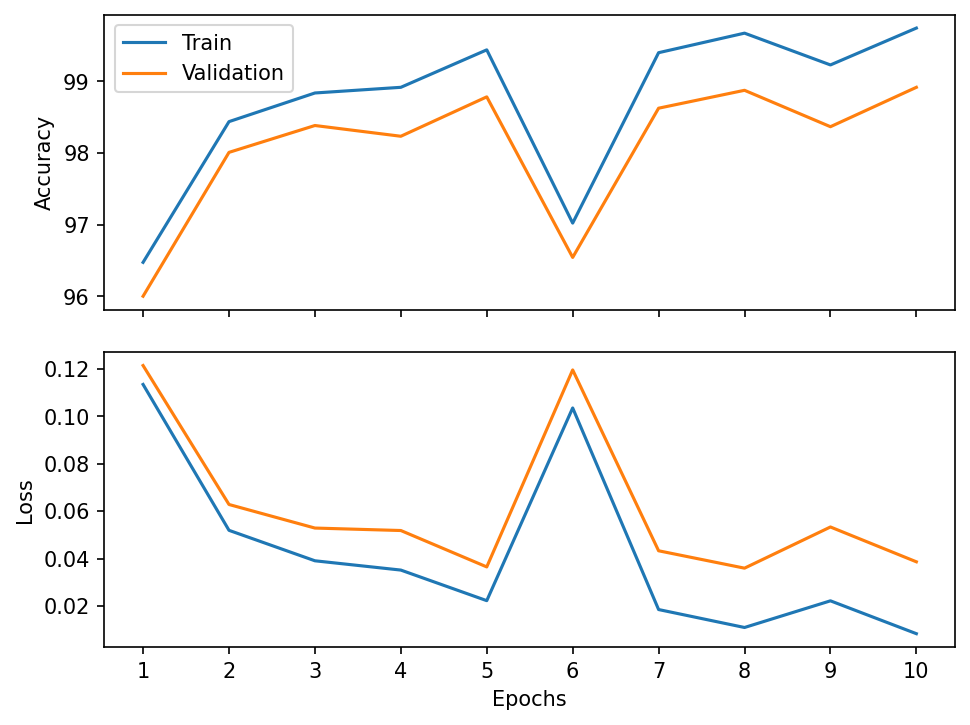

In [15]:
history.display()

Finalement, évaluons les performances du modèle sur le jeu de données de test.

In [16]:
test(model, mnist_test, batch_size, use_gpu=True)

Test acc: 98.90 - Test loss: 0.0332


## Différences CPU - GPU

Pour faire exécuter le code sur GPU, il faut déplacer le model, les inputs et les targets sur le GPU.

Le réseau contient deux couches de convolutions qui servent à extraire des caractéristiques des images tandis que les couches linéaires servent de classifieur. Il s'agit d'un pipeline commun pour toutes les classes.

In [17]:
model_gpu = MnistNet()
model_gpu.cuda()

MnistNet(
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(10, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=2450, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

Comparons le temps d'exécution sur CPU et sur GPU. Pour ce faire, entraînons le réseau pour 5 epochs sur CPU et 5 epochs sur GPU et comparons les temps de traitement.

In [18]:
epoch = 5
batch_size = 256
lr = 0.1

Pendant l'entraînement, vérifier l'utilisation du CPU avec la commande ``top`` (ou ``htop``). Voir la section "Utilisation de commandes" tout en haut du notebook pour l'utilisation de commande.

In [19]:
print('Training on CPU')
model = MnistNet()

start_cpu = time.time()
history = train(model, mnist, epoch, batch_size, lr)
end_cpu = time.time()

cpu_time = end_cpu - start_cpu

Training on CPU
Epoch 0 - Train acc: 84.74 - Val acc: 84.50 - Train loss: 0.4547 - Val loss: 0.4590
Epoch 1 - Train acc: 91.88 - Val acc: 91.14 - Train loss: 0.2449 - Val loss: 0.2603
Epoch 2 - Train acc: 96.44 - Val acc: 96.08 - Train loss: 0.1149 - Val loss: 0.1226
Epoch 3 - Train acc: 97.09 - Val acc: 96.62 - Train loss: 0.0932 - Val loss: 0.1058
Epoch 4 - Train acc: 97.94 - Val acc: 97.42 - Train loss: 0.0670 - Val loss: 0.0787


Pour vous assurer que le réseau entraîne bien sur GPU, utiliser la commande

``watch -n 1 nvidia-smi``

Observer l'utilisation de la carte et la quantité de mémoire utilisée pendant l'entraînement.

In [20]:
print('Training on GPU')
model_gpu = MnistNet()
model_gpu.cuda()

start_gpu = time.time()
history_gpu = train(model_gpu, mnist, epoch, batch_size, lr, use_gpu=True)
end_gpu = time.time()

gpu_time = end_gpu - start_gpu

Training on GPU
Epoch 0 - Train acc: 87.42 - Val acc: 87.10 - Train loss: 0.4138 - Val loss: 0.4207
Epoch 1 - Train acc: 94.99 - Val acc: 94.63 - Train loss: 0.1651 - Val loss: 0.1717
Epoch 2 - Train acc: 96.30 - Val acc: 95.89 - Train loss: 0.1202 - Val loss: 0.1260
Epoch 3 - Train acc: 97.31 - Val acc: 97.03 - Train loss: 0.0883 - Val loss: 0.0940
Epoch 4 - Train acc: 97.18 - Val acc: 96.86 - Train loss: 0.0903 - Val loss: 0.0965


In [21]:
print('CPU - Training time: {:.2f}s'.format(cpu_time))
print('GPU - Training time: {:.2f}s'.format(gpu_time))
print('Ratio: {:.2f}x'.format((cpu_time) / (gpu_time)))

CPU - Training time: 188.43s
GPU - Training time: 60.53s
Ratio: 3.11x


## CIFAR 10

CIFAR-10 est un jeu de données comportant des images séparés en 10 classes:<br>
0 - Avion<br>
1 - Voiture<br>
2 - Oiseau<br>
3 - Chat<br>
4 - Chevreuil<br>
5 - Chien<br>
6 - Grenouille<br>
7 - Cheval<br>
8 - Bateau<br>
9 - Camion<br>

Le jeu de données contient 50000 images d'entraînement. On en utilisera 40000 pour l'entraînement et 10000 pour la validation.

### Visualisation du jeu de données

In [8]:
cifar, cifar_test = load_cifar10()

100%|██████████| 170M/170M [00:05<00:00, 30.8MB/s]


Encore une fois, vous pouvez exécuter cette cellule plusieurs fois pour bien visualiser le jeu de données.

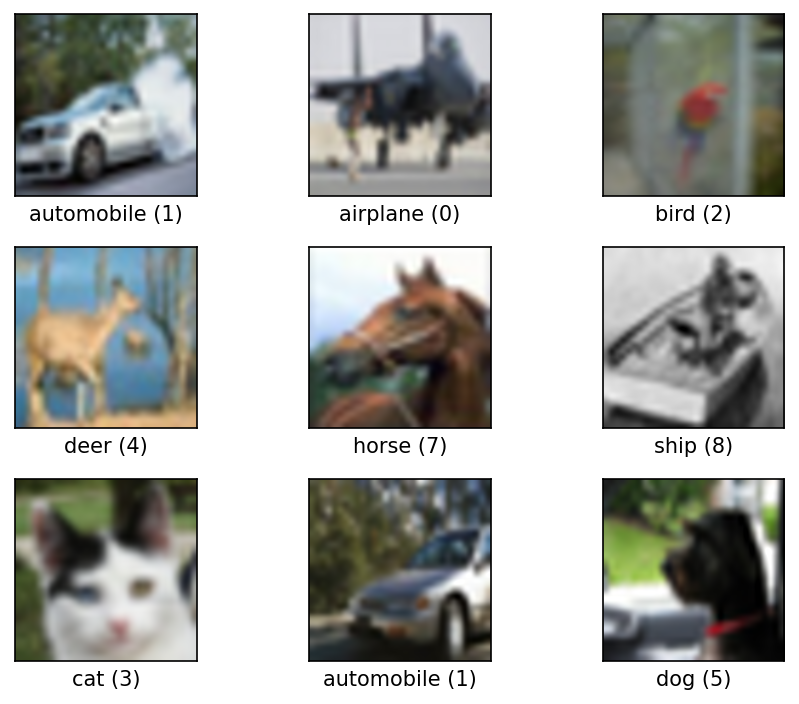

In [24]:
label_names = [
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck'
]

idx = random.sample([x for x in range(len(cifar))], 9)
images = [np.array(cifar[i][0]) for i in idx]
images = np.asarray(images)
targets = [cifar[i][1] for i in idx]

plot_images(images, targets, label_names=label_names)

Encore une fois, on désire obtenir des tensors de notre dataset.

In [9]:
cifar.transform = ToTensor()
cifar_test.transform = ToTensor()

#### Exercices

- Pour répondre aux questions suivantes, vous avez le contenu de ces 3 cellules.

In [26]:
epoch = 5
batch_size = 64
learning_rate = 0.1

model = CifarNet()
model.cuda()

history = train(model, cifar, epoch, batch_size, learning_rate, use_gpu=True)

Epoch 0 - Train acc: 45.31 - Val acc: 44.74 - Train loss: 1.5497 - Val loss: 1.5705
Epoch 1 - Train acc: 54.76 - Val acc: 52.82 - Train loss: 1.2757 - Val loss: 1.3309
Epoch 2 - Train acc: 64.79 - Val acc: 60.74 - Train loss: 1.0197 - Val loss: 1.1231
Epoch 3 - Train acc: 69.65 - Val acc: 64.20 - Train loss: 0.8818 - Val loss: 1.0319
Epoch 4 - Train acc: 72.80 - Val acc: 65.81 - Train loss: 0.7955 - Val loss: 0.9869


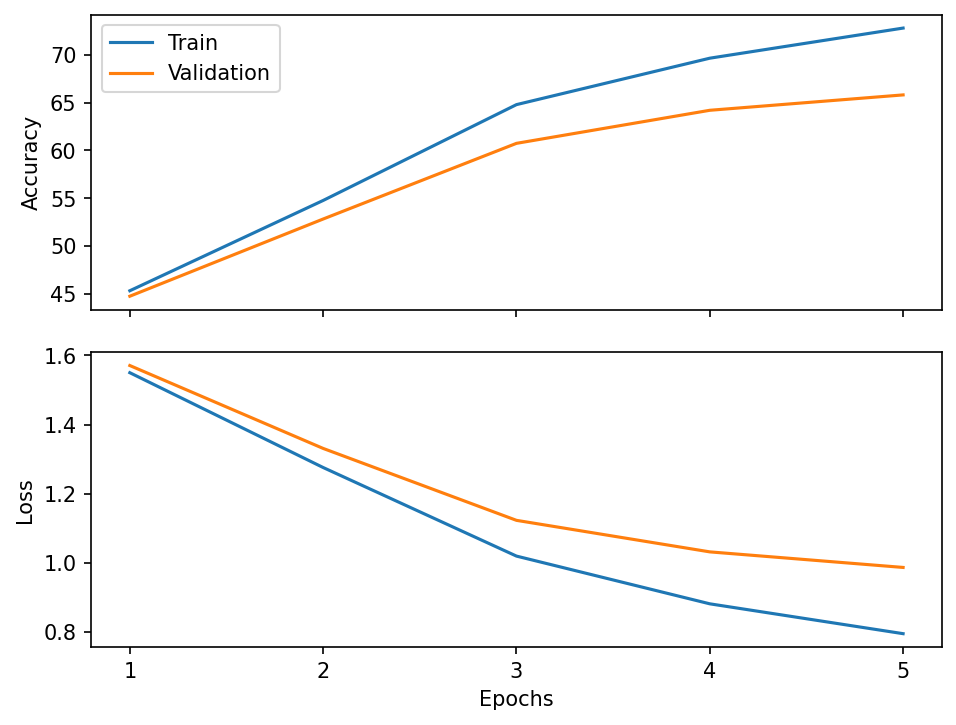

In [27]:
history.display()

In [28]:
test(model, cifar_test, batch_size, use_gpu=True)

Test acc: 65.94 - Test loss: 0.9815


### Effet du nombre d'epochs

#### Exercice

- Modifiez le nombre d'epochs et observez les performances du réseau.

#### Questions

- Que se passe-t-il s'il est trop petit? On apprend pas comme il faut les classes.
- Que se passe-t-il s'il est trop grand? On overfit sur les données que nous avons vu et le test en écope

Epoch 0 - Train acc: 39.08 - Val acc: 37.94 - Train loss: 1.6364 - Val loss: 1.6590


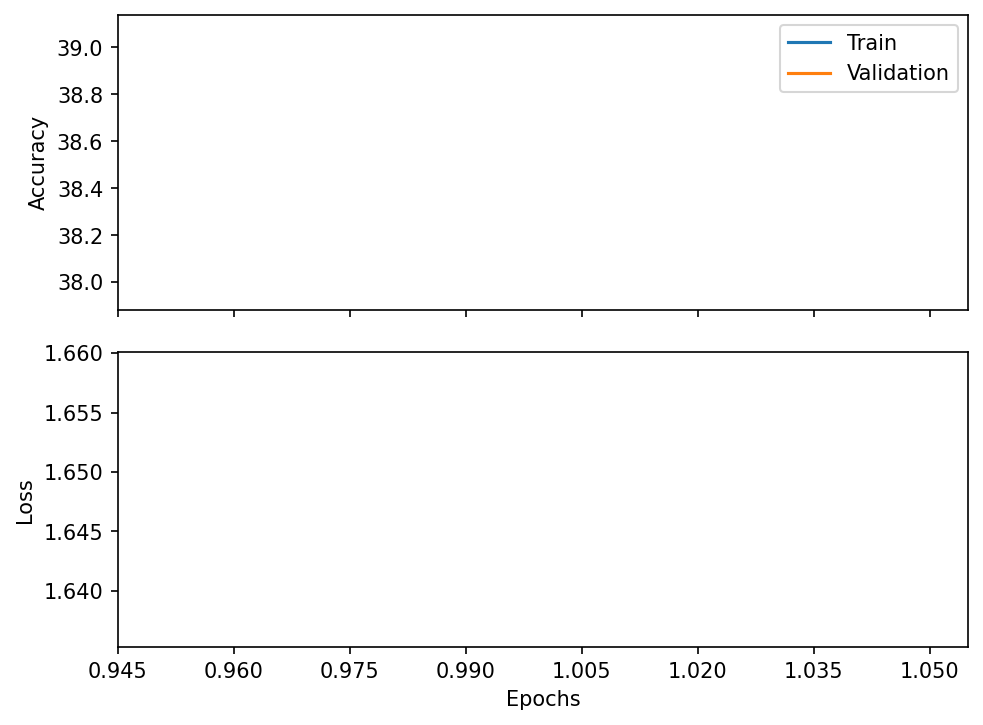

Test acc: 38.19 - Test loss: 1.6469


In [30]:
epoch = 1
batch_size = 64
learning_rate = 0.1

model = CifarNet()
model.cuda()

history = train(model, cifar, epoch, batch_size, learning_rate, use_gpu=True)
history.display()
test(model, cifar_test, batch_size, use_gpu=True)

### Effet de la taille de la batch

#### Exercice

- Modifiez la taille de la batch et observez l'utilisation de la carte graphique.

#### Questions

- Sur quoi est-ce que la taille de la batch semble avoir le plus d'impact? Sur la mémoire utilisé dans le GPU, on load plus d'images à la fois avec une plus grosse batch.

    **Note**: Pour pouvoir observer les changements au niveau de l'utilisation de la mémoire du GPU, il est préférable de redémarrer le kernel du notebook entre chaque tentative (dans le menu Kernel). Si vous prenez ce chemin, n'oubliez pas d'exécuter les cellules nécessaires plus haut dans le notebook (les imports, les fonctions train, validate, etc.).
    
- Est-ce qu'elle impacte les performances? Elle diminue les performances initiallement car on entraîne et valide sur plus d'images à la fois donc plus d'erreurs, par contre la validation et le test sont plus fidèles à la performance de l'entraînement.
- Que peut-on conclure sur la taille de batch optimale? La taille optimale serait donc la taille la plus grande pouvant être stockée en mémoire par le GPU.

     **Note**: on ne demande pas de trouver cette taille optimale mais de commenter sur la manière dont on la trouverait.

Epoch 0 - Train acc: 48.39 - Val acc: 47.37 - Train loss: 1.4567 - Val loss: 1.4783
Epoch 1 - Train acc: 59.36 - Val acc: 56.97 - Train loss: 1.1662 - Val loss: 1.2319
Epoch 2 - Train acc: 65.53 - Val acc: 61.60 - Train loss: 1.0060 - Val loss: 1.1061
Epoch 3 - Train acc: 69.14 - Val acc: 63.86 - Train loss: 0.8846 - Val loss: 1.0300
Epoch 4 - Train acc: 74.30 - Val acc: 67.17 - Train loss: 0.7451 - Val loss: 0.9662


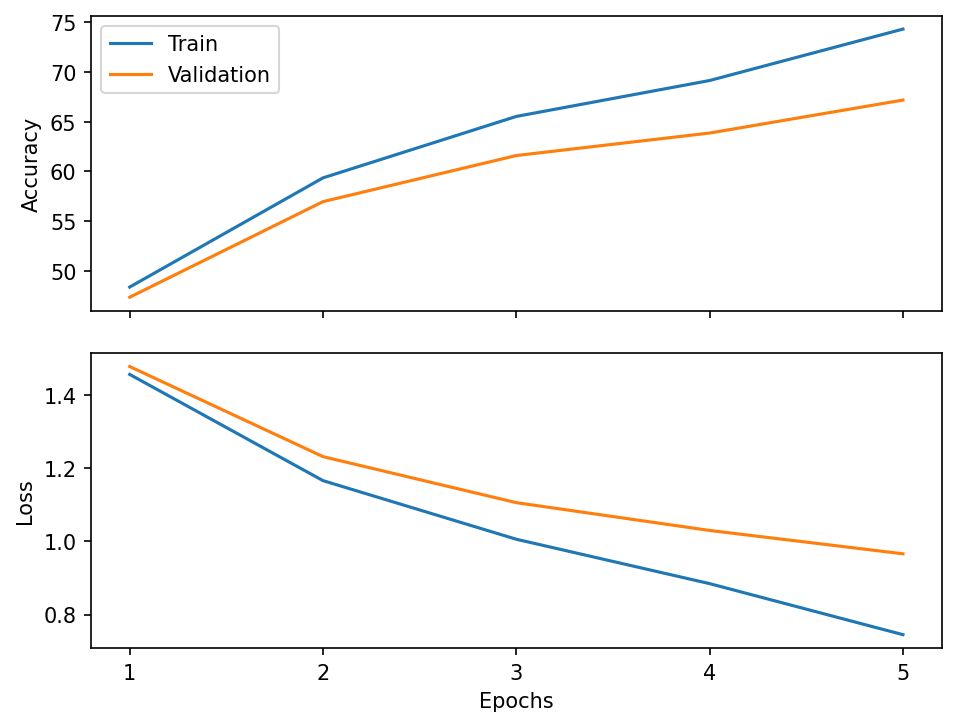

Test acc: 67.28 - Test loss: 0.9534


In [31]:
epoch = 5
batch_size = 64
learning_rate = 0.1

model = CifarNet()
model.cuda()

history = train(model, cifar, epoch, batch_size, learning_rate, use_gpu=True)
history.display()
test(model, cifar_test, batch_size, use_gpu=True)

Epoch 0 - Train acc: 13.04 - Val acc: 12.30 - Train loss: 2.2922 - Val loss: 2.2931
Epoch 1 - Train acc: 18.58 - Val acc: 18.50 - Train loss: 2.2633 - Val loss: 2.2648
Epoch 2 - Train acc: 16.12 - Val acc: 15.99 - Train loss: 2.3024 - Val loss: 2.3143
Epoch 3 - Train acc: 22.99 - Val acc: 23.44 - Train loss: 2.1543 - Val loss: 2.1578
Epoch 4 - Train acc: 26.95 - Val acc: 27.72 - Train loss: 2.0629 - Val loss: 2.0642


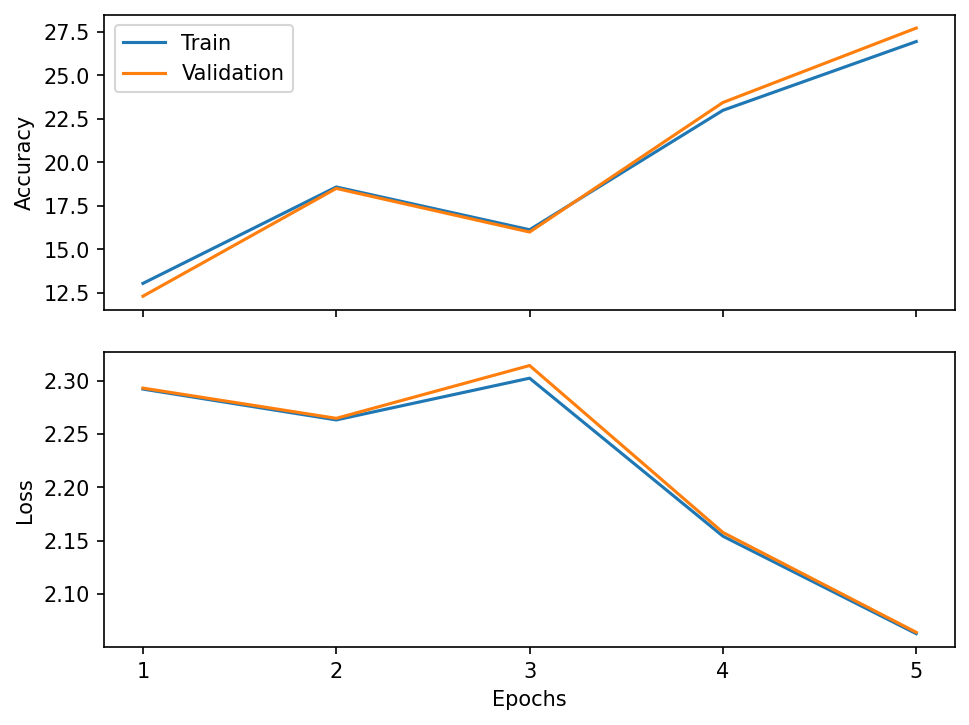

Test acc: 27.73 - Test loss: 2.0565


In [10]:
epoch = 5
batch_size = 3000
learning_rate = 0.1

model = CifarNet()
model.cuda()

history = train(model, cifar, epoch, batch_size, learning_rate, use_gpu=True)
history.display()
test(model, cifar_test, batch_size, use_gpu=True)

### Effet du taux d'apprentissage (lr)

Finalement, observez l'impact du taux d'apprentissage sur l'entraînement.

#### Questions

- Que se passe-t-il s'il est trop grand? Les poids varient trop rapidement et ne permettent pas l'atteinte d'une performance optimale en oscillant de part et d'autre de la valeur minimisant la perte. Le réseau peut aussi ne pas apprendre ni gagner en performance si le lr est vraiment trop grand.
- S'il est trop petit? L'entraînement n'apprend que très très lentement voire n'apprend pas les bons poids, ce qui ne permet pas au réseau d'arriver à de bonnes performances. L'entraînement sera donc très long et nécessitera beaucoup d'epoch.

Epoch 0 - Train acc: 47.63 - Val acc: 46.30 - Train loss: 1.4529 - Val loss: 1.4864
Epoch 1 - Train acc: 57.16 - Val acc: 54.43 - Train loss: 1.2213 - Val loss: 1.2844
Epoch 2 - Train acc: 65.13 - Val acc: 61.28 - Train loss: 1.0036 - Val loss: 1.1084
Epoch 3 - Train acc: 69.69 - Val acc: 63.04 - Train loss: 0.8826 - Val loss: 1.0499
Epoch 4 - Train acc: 69.55 - Val acc: 62.01 - Train loss: 0.8677 - Val loss: 1.1042


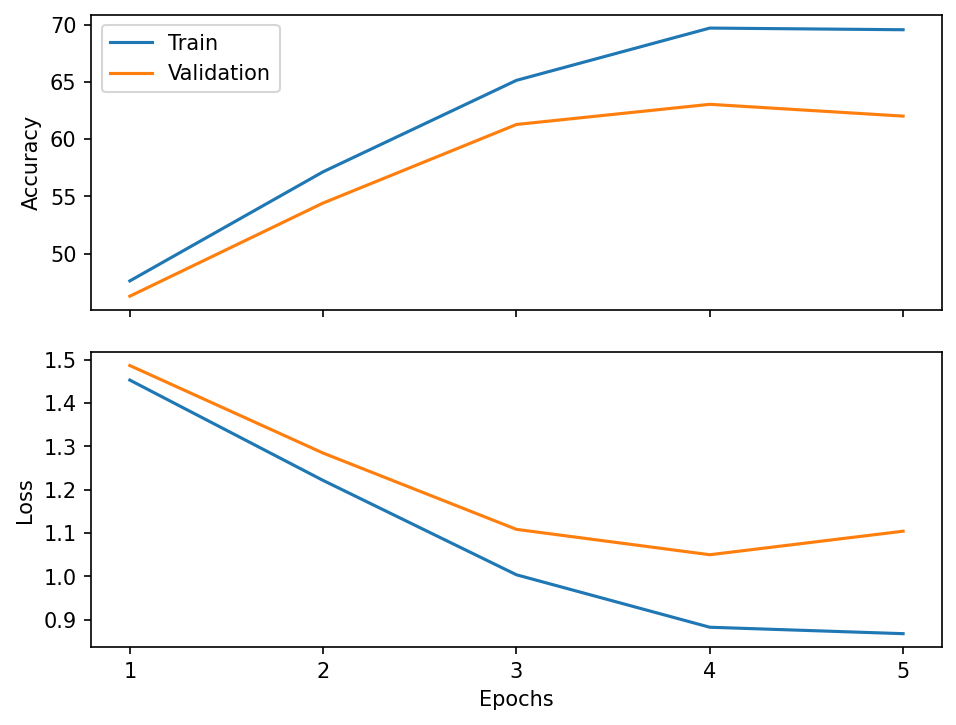

Test acc: 62.51 - Test loss: 1.0967


In [11]:
epoch = 5
batch_size = 64
learning_rate = 0.1

model = CifarNet()
model.cuda()

history = train(model, cifar, epoch, batch_size, learning_rate, use_gpu=True)
history.display()
test(model, cifar_test, batch_size, use_gpu=True)

Epoch 0 - Train acc: 27.41 - Val acc: 27.94 - Train loss: 2.0206 - Val loss: 2.0146
Epoch 1 - Train acc: 38.82 - Val acc: 38.42 - Train loss: 1.7347 - Val loss: 1.7394
Epoch 2 - Train acc: 43.84 - Val acc: 43.72 - Train loss: 1.5836 - Val loss: 1.5912
Epoch 3 - Train acc: 46.46 - Val acc: 45.90 - Train loss: 1.5064 - Val loss: 1.5236
Epoch 4 - Train acc: 47.29 - Val acc: 46.35 - Train loss: 1.4763 - Val loss: 1.4933


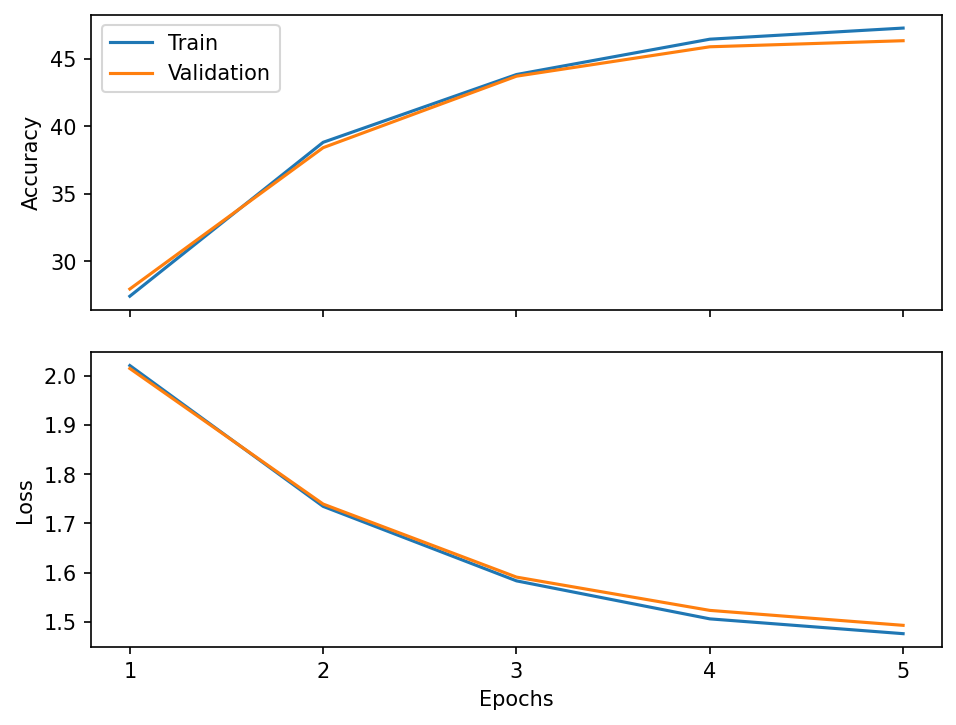

Test acc: 46.80 - Test loss: 1.4811


In [13]:
epoch = 5
batch_size = 64
learning_rate = 0.01

model = CifarNet()
model.cuda()

history = train(model, cifar, epoch, batch_size, learning_rate, use_gpu=True)
history.display()
test(model, cifar_test, batch_size, use_gpu=True)

### Défi

- Modifiez les hyperparamètres pour améliorer les performances du réseau.<br>
Essayez d'obtenir plus de 65% en test.

- Vous pouvez aussi tenter de battre l'état de l'art: http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html#43494641522d3130

Epoch 0 - Train acc: 37.71 - Val acc: 37.16 - Train loss: 1.7535 - Val loss: 1.7579
Epoch 1 - Train acc: 46.47 - Val acc: 45.63 - Train loss: 1.4954 - Val loss: 1.5309
Epoch 2 - Train acc: 52.70 - Val acc: 50.77 - Train loss: 1.3174 - Val loss: 1.3663
Epoch 3 - Train acc: 54.20 - Val acc: 51.71 - Train loss: 1.2692 - Val loss: 1.3452
Epoch 4 - Train acc: 59.97 - Val acc: 56.75 - Train loss: 1.1454 - Val loss: 1.2294
Epoch 5 - Train acc: 65.55 - Val acc: 61.11 - Train loss: 1.0089 - Val loss: 1.1176
Epoch 6 - Train acc: 66.90 - Val acc: 61.96 - Train loss: 0.9408 - Val loss: 1.0800
Epoch 7 - Train acc: 66.55 - Val acc: 61.01 - Train loss: 0.9426 - Val loss: 1.1209
Epoch 8 - Train acc: 70.59 - Val acc: 63.85 - Train loss: 0.8437 - Val loss: 1.0349
Epoch 9 - Train acc: 74.02 - Val acc: 66.05 - Train loss: 0.7516 - Val loss: 0.9971
Epoch 10 - Train acc: 72.83 - Val acc: 63.97 - Train loss: 0.7810 - Val loss: 1.0616
Epoch 11 - Train acc: 74.48 - Val acc: 64.76 - Train loss: 0.7358 - Val los

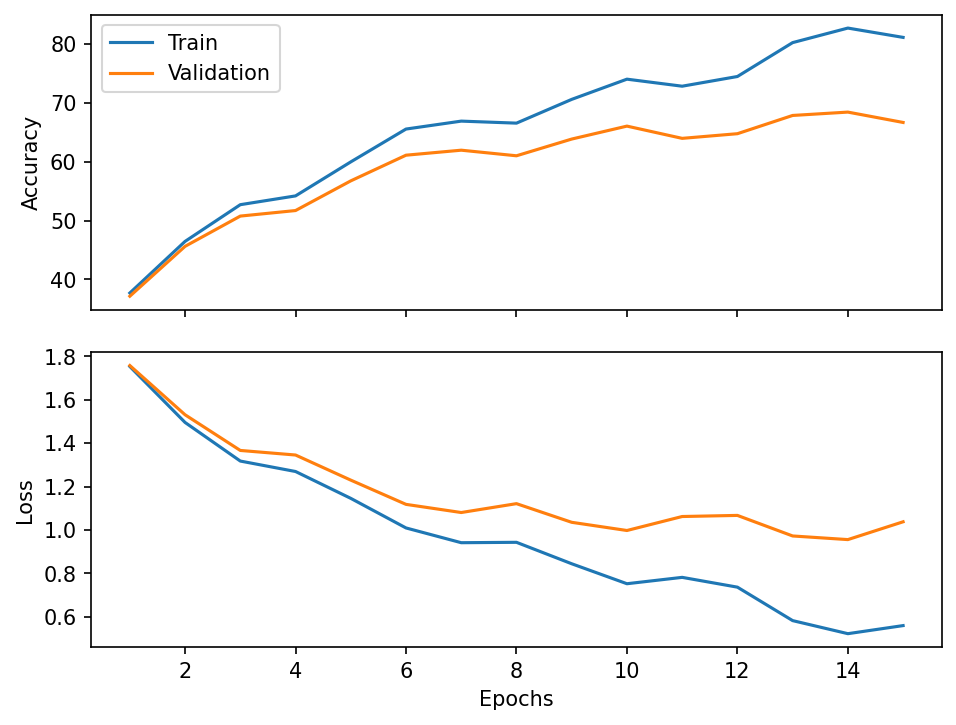

Test acc: 66.35 - Test loss: 1.0464


In [14]:
epoch = 15
batch_size = 128
learning_rate = 0.075

model = CifarNet()
model.cuda()

history = train(model, cifar, epoch, batch_size, learning_rate, use_gpu=True)
history.display()
test(model, cifar_test, batch_size, use_gpu=True)

## Utilisation d'une librairie pour l'entraînement

Comme vous l'avez peut-être remarqué, les fonctions `train` et `test` que nous avons utilisées sont bien pratiques. Il existe différentes librairies nous permettant de ne pas devoir définir ces fonctions pour chacun de nos projets. Lorsqu'approprié, nous utiliserons une de ces librairies dans les laboratoires de ce cours. Nous avons choisi d'utiliser la librairie [Poutyne](https://poutyne.org/) qui est développée ici même à l'Université Laval.

Définissons nos hyperparamètres usuels.

In [10]:
epoch = 5
batch_size = 64
learning_rate = 0.1

Poutyne peut prendre en entrée des Numpy arrays ou des tenseurs via sa méthode `fit` ou bien des objets qui sont itérables comme des `DataLoader` de PyTorch via sa méthode `fit_generator`. Définissons donc des `DataLoader` comme le font les fonctions `train` et `test`.

In [11]:
train_loader, valid_loader = train_valid_loaders(cifar, batch_size=batch_size)
test_loader = DataLoader(cifar_test, batch_size=batch_size)

Importons Poutyne.

In [12]:
import poutyne as pt

Procédons maintenant à l'entraînement. La principale classe de Poutyne est la classe [`Model`](https://poutyne.org/model.html) qui nous servira à effectuer l'entraînement. Également, n'hésitez pas à jeter un coup d'oeil à la classe [`Experiment`](https://poutyne.org/experiment.html) qui permet de sauvegarder automatiquement un tas d'information comme des points de sauvegarde (checkpoints) et des logs.

/usr/local/lib/python3.12/dist-packages/poutyne/framework/metrics/decomposable.py:59: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:836.)
  values = [float(output)]


Epoch: 1/5 Train steps: 625 Val steps: 157 10.92s loss: 1.843143 acc: 33.417500 val_loss: 1.500555 val_acc: 47.580000
Epoch: 2/5 Train steps: 625 Val steps: 157 9.10s loss: 1.366907 acc: 51.530000 val_loss: 1.271542 val_acc: 55.530000
Epoch: 3/5 Train steps: 625 Val steps: 157 8.48s loss: 1.170382 acc: 58.995000 val_loss: 1.151848 val_acc: 59.550000
Epoch: 4/5 Train steps: 625 Val steps: 157 9.08s loss: 1.013350 acc: 64.350000 val_loss: 1.079848 val_acc: 61.990000
Epoch: 5/5 Train steps: 625 Val steps: 157 9.05s loss: 0.896592 acc: 68.877500 val_loss: 0.979758 val_acc: 66.120000


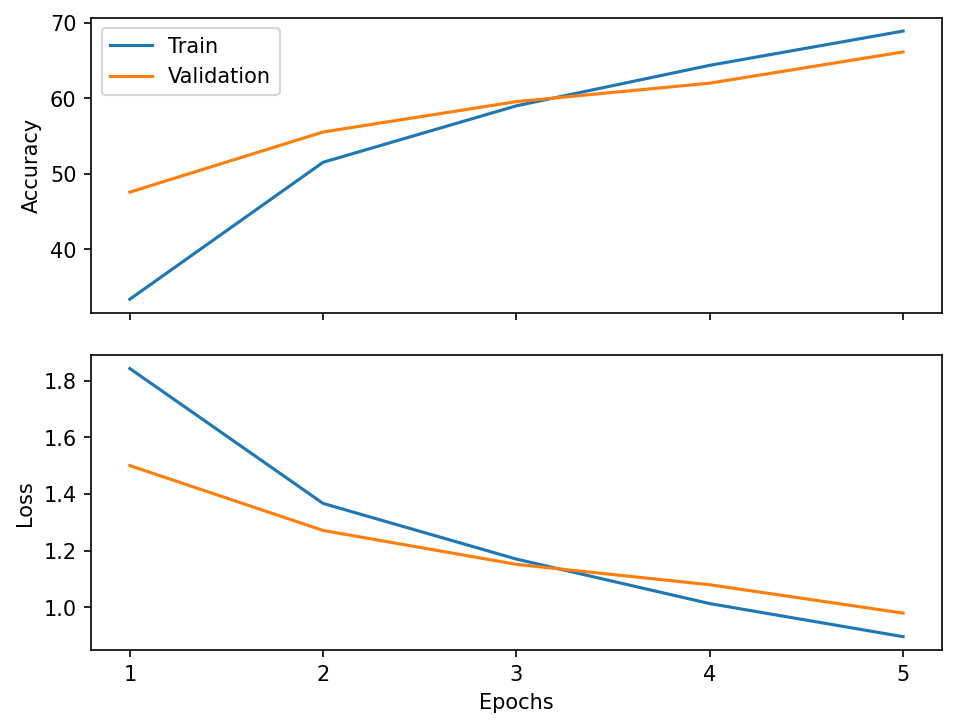

Test steps: 157 1.40s test_loss: 0.979102 test_acc: 66.140000                                 
test_loss: 0.9791 test_acc: 66.14


In [13]:
# On instance notre réseau ainsi que l'optimiseur comme à l'habitude.
net = CifarNet()
optimizer = optim.SGD(net.parameters(), lr=learning_rate)

# On crée un objet Model de Poutyne avec la fonction de perte et les métriques souhaitées.
model = pt.Model(net, optimizer, 'cross_entropy', batch_metrics=['accuracy'])
model.cuda()

# Comme dit précedemment, on utilise la méthode `fit_generator` pour procéder à l'entraînement.
history = model.fit_generator(train_loader, valid_loader, epochs=epoch)

# La classe History peut aussi prendre un historique de Poutyne en entrée.
History(history).display()

# Finalement, on utilise la fonction evaluate_generator pour calculer la perte et l'exactitude sur
# notre ensemble de test.
test_loss, test_acc = model.evaluate_generator(test_loader)
print('test_loss: {:.4f} test_acc: {:.2f}'.format(test_loss, test_acc))

### Pour aller plus loin

Un aspect intéressant de Poutyne est l'utilisation de [callbacks](https://poutyne.org/callbacks.html) qui permettent d'effectuer des actions pendant l'entraînement. Dans l'exemple suivant, on utilise deux types de callbacks: un permettant de faire des points de sauvegarde et l'autre permettant de logger dans un CSV les statistiques d'entraînement.

In [14]:
net = CifarNet()
optimizer = optim.SGD(net.parameters(), lr=learning_rate)

os.makedirs('logs', exist_ok=True)

callbacks = [
    # Effectue des points de sauvegarde après chaque epoch dans le fichier last_epoch.ckpt.
    pt.ModelCheckpoint('logs/last_epoch.ckpt', temporary_filename='last_epoch.ckpt.tmp'),

    # Effectue des points de sauvegarde à chaque fois qu'il y a amélioration de l'exactitude
    # en validation. Le nom du fichier va contenir le numéro de l'epoch correspondante.
    pt.ModelCheckpoint('logs/best_epoch_{epoch}.ckpt', monitor='val_acc', mode='max', save_best_only=True, restore_best=True, verbose=True, temporary_filename='best_epoch.ckpt.tmp'),

    # Sauvegarde toutes les stats affichés dans un fichier CSV.
    pt.CSVLogger('logs/log.csv'),
]

model = pt.Model(net, optimizer, 'cross_entropy', batch_metrics=['accuracy'])
model.cuda()

history = model.fit_generator(train_loader, valid_loader, epochs=epoch, callbacks=callbacks)

Epoch: 1/5 Train steps: 625 Val steps: 157 11.49s loss: 1.879118 acc: 32.400000 val_loss: 1.497568 val_acc: 46.500000
Epoch 1: val_acc improved from -inf to 46.50000, saving file to logs/best_epoch_1.ckpt
Epoch: 2/5 Train steps: 625 Val steps: 157 9.09s loss: 1.376054 acc: 51.195000 val_loss: 1.321214 val_acc: 54.040000
Epoch 2: val_acc improved from 46.50000 to 54.04000, saving file to logs/best_epoch_2.ckpt
Epoch: 3/5 Train steps: 625 Val steps: 157 9.23s loss: 1.164400 acc: 59.100000 val_loss: 1.122185 val_acc: 60.750000
Epoch 3: val_acc improved from 54.04000 to 60.75000, saving file to logs/best_epoch_3.ckpt
Epoch: 4/5 Train steps: 625 Val steps: 157 8.58s loss: 1.003222 acc: 64.935000 val_loss: 1.068919 val_acc: 62.950000
Epoch 4: val_acc improved from 60.75000 to 62.95000, saving file to logs/best_epoch_4.ckpt
Epoch: 5/5 Train steps: 625 Val steps: 157 9.08s loss: 0.879761 acc: 69.642500 val_loss: 0.991370 val_acc: 65.730000
Epoch 5: val_acc improved from 62.95000 to 65.73000, s

Une fois l'entraînement effectué, on peut aller lire le fichier de log CSV avec la librairie pandas.

In [15]:
pd.read_csv('logs/log.csv')

,epoch,time,lr,loss,acc,val_loss,val_acc
0,1,11.487774,0.1,1.879118,32.4000,1.497568,46.50
1,2,9.088730,0.1,1.376054,51.1950,1.321214,54.04
2,3,9.228310,0.1,1.164400,59.1000,1.122185,60.75
3,4,8.577914,0.1,1.003222,64.9350,1.068919,62.95
4,5,9.075534,0.1,0.879761,69.6425,0.991370,65.73


Étant donné le court entraînement, on devrait avoir obtenu des points de sauvegarde pour chacun des epochs. Amusez vous à charger différents epochs et à regarder l'impact sur l'ensemble de test.

In [17]:
model.load_weights('logs/best_epoch_1.ckpt')
test_loss, test_acc = model.evaluate_generator(test_loader)
print('Epoch 4: test_loss: {:.4f} test_acc: {:.2f}'.format(test_loss, test_acc))

model.load_weights('logs/best_epoch_5.ckpt')
test_loss, test_acc = model.evaluate_generator(test_loader)
print('Epoch 5: test_loss: {:.4f} test_acc: {:.2f}'.format(test_loss, test_acc))

Test steps: 157 1.70s test_loss: 1.470624 test_acc: 47.100000                                 
Epoch 4: test_loss: 1.4706 test_acc: 47.10
Test steps: 157 1.41s test_loss: 0.986375 test_acc: 65.830000                                 
Epoch 5: test_loss: 0.9864 test_acc: 65.83
